In [122]:
import pandas as pd
import numpy as np
import copy
import random
from math import sqrt
import scipy.stats as sts

from tqdm import tqdm_notebook

from supplement_package import game
from supplement_package import variables_pecan

pd.options.mode.chained_assignment = None  # default='warn'

In [123]:
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

In [124]:
from supplement_package.game.stackelberg import StackelbergPlayer

In [125]:
import gurobipy as gp

from supplement_package.gurobi_implementation.gurobi import GurobiSolution

## Data preliminaries 

In [126]:
agent_keys = [661, 1642, 2335, 2361, 2818, 3039, 3456, 3538, 4031, 4373, 4767, 5746, 6139, 7536, 7719, 7800, 7901, 7951, 8156, 8386, 8565, 9019, 9160, 9922, 9278]

dataframe_dict = dict()
for key in agent_keys:
    dataframe_dict.update({key : pd.read_csv('/Users/ishilov/Documents/risk_paper/risk_paper/data/df_{}.csv'.format(key))})

community_size = len(dataframe_dict)

for key in agent_keys:
    cond_min = (dataframe_dict[key]['demand'].quantile(0.01) <= dataframe_dict[key]['demand'])
    cond_max = (dataframe_dict[key]['demand'] <= dataframe_dict[key]['demand'].quantile(0.99))
    dataframe_dict[key] = dataframe_dict[key][cond_min & cond_max]

In [127]:
def generate_new_params(sample_size, community_size):
    res = {}

    for sample in range(sample_size):
        A_tilde = [random.uniform(0,1) for i in range(community_size)]
        B_tilde = [random.uniform(0,1) for i in range(community_size)]

        a = [random.uniform(0,1) for i in range(community_size)]
        b = [random.uniform(0,1) for i in range(community_size)]
        d = [random.uniform(0,1) for i in range(community_size)]

        #d_target = [[random.uniform(0,8) for j in range(len(probabilities))] for i in range(community_size)]
        #g_res = [[random.uniform(0,3) for j in range(len(probabilities))] for i in range(community_size)]

        #g_res = np.array(g_res)
        #d_target = np.array(d_target)

        risk_aversion = [random.uniform(0,1) for i in range(community_size)]

        res.update({sample : {'A_tilde' : A_tilde,
                        'B_tilde' : B_tilde,
                        'a' : a,
                        'b' : b,
                        'd' : d,
                        'risk_aversion' : risk_aversion}})

    res_reformed = {(i, key) : res[i][key] for i in range(sample_size) for key in res[0].keys()}
    mindx = pd.MultiIndex.from_tuples(res_reformed.keys())
    df = pd.DataFrame(list(res_reformed.values()), index = mindx)
    df.to_csv(f'../data/param_{sample_size}.csv')


In [128]:
def generate_new_params_big(sample_size, community_size):
    res = {}

    for sample in range(sample_size):
        A_tilde = [random.uniform(0,20) for i in range(community_size)]
        B_tilde = [random.uniform(0,20) for i in range(community_size)]

        a = [random.uniform(0,20) for i in range(community_size)]
        b = [random.uniform(0,20) for i in range(community_size)]
        d = [random.uniform(0,20) for i in range(community_size)]

        #d_target = [[random.uniform(0,8) for j in range(len(probabilities))] for i in range(community_size)]
        #g_res = [[random.uniform(0,3) for j in range(len(probabilities))] for i in range(community_size)]

        #g_res = np.array(g_res)
        #d_target = np.array(d_target)

        risk_aversion = [random.uniform(0,1) for i in range(community_size)]

        res.update({sample : {'A_tilde' : A_tilde,
                        'B_tilde' : B_tilde,
                        'a' : a,
                        'b' : b,
                        'd' : d,
                        'risk_aversion' : risk_aversion}})

    res_reformed = {(i, key) : res[i][key] for i in range(sample_size) for key in res[0].keys()}
    mindx = pd.MultiIndex.from_tuples(res_reformed.keys())
    df = pd.DataFrame(list(res_reformed.values()), index = mindx)
    df.to_csv(f'../data/param_big_{sample_size}.csv')

In [129]:
def text_to_adj_matrix(matrix_path):
    res = []
    with open(matrix_path) as file:
        for s in file:
            string = ''.join(s.strip().strip(',').split(', '))
            lst_temp = [int(sym) for sym in string]

            res.append(lst_temp)

    return res

In [130]:
#generate_new_params_big(1000)

In [131]:
def read_df_param(sample_size):
    df_param = pd.read_csv(f'../data/param_{sample_size}.csv')
    df_param.rename({'Unnamed: 0' : 'Sample', 'Unnamed: 1' : 'Parameter'}, axis=1, inplace= True)
    df_param.set_index(['Sample', 'Parameter'], inplace=True)

    return df_param

In [132]:
def read_df_param_big(sample_size):
    df_param = pd.read_csv(f'../data/param_big_{sample_size}.csv')
    df_param.rename({'Unnamed: 0' : 'Sample', 'Unnamed: 1' : 'Parameter'}, axis=1, inplace= True)
    df_param.set_index(['Sample', 'Parameter'], inplace=True)

    return df_param

In [133]:
def distribution_build(sample_size, agent_keys):
    res = {}
    
    for key in agent_keys:
        #chunks_demand = int(demand_dict[key][0].size / sample_size)
        #chunks_generation = int(solar_dict[key][0].size / sample_size)


        #probas_demand = [np.trapz(demand_dict[key][1][i * sample_size : (i + 1) * sample_size],
        #                            demand_dict[key][0][i * sample_size : (i + 1) * sample_size])
        #                            for i in range(chunks_demand)]

        #probas_generation = [np.trapz(generation_dict[key][1][i * sample_size : (i + 1) * sample_size],
        #                            generation_dict[key][0][i * sample_size : (i + 1) * sample_size])
        #                            for i in range(chunks_generation)]

        #res_demand = plt.hist(np.random.choice(demand_dict[key][0], size = sample_size, p = probabilities), bins = int(sample_size / 2))
        #probas_update = res_demand[0] / res_demand[0].sum() if key == 661 else res[661]['probabilities']
        #res.update({key : 
        #            {'values' : res_demand[1], 
        #            'probabilities' : probas_update}})

        hist_demand = plt.hist(dataframe_dict[key]['demand'], bins = sample_size)
        probas_demand, values_demand = hist_demand[0], hist_demand[1]
        probas_demand = probas_demand / probas_demand.sum()

        if 'solar' in dataframe_dict[key].columns:
            hist_solar = plt.hist(dataframe_dict[key][dataframe_dict[key]['solar'] >= 0]['solar'], bins = sample_size)
            probas_solar , values_solar  = hist_solar[0], hist_solar[1]
            probas_solar = probas_demand / probas_demand.sum()

        res.update({key : 
                    {'probas_demand' : probas_demand,
                    'values_demand' : values_demand,
                    'probas_solar' : probas_solar,
                    'values_solar' : values_solar}})

    return res 

In [134]:
def scenario_sampling(sample_size, agent_keys, main_key = 661):
    distribution = distribution_build(sample_size, agent_keys)

    probabilities = distribution[main_key]['probas_demand']

    d_target = []
    g_res = []
    for key in agent_keys:
        d_target.append(distribution[key]['values_demand'][:-1])
        g_res.append(distribution[key]['values_solar'][:-1])

    return probabilities, d_target, g_res

In [135]:
def param_input(df, index = 0):
    A_tilde = list(df.loc[index].loc['A_tilde'])
    B_tilde = list(df.loc[index].loc['B_tilde'])
    a = list(df.loc[index].loc['a'])
    b = list(df.loc[index].loc['b'])
    d = list(df.loc[index].loc['d'])
    risk_aversion = list(df.loc[index].loc['risk_aversion'])

    for i, RA in enumerate(risk_aversion):
        if RA > 0.95:
            risk_aversion[i] = risk_aversion[i] - 0.1

    return A_tilde, B_tilde, a, b, d, risk_aversion

In [136]:
param_amount = 2000

#generate_new_params_big(param_amount,community_size=community_size)
df_param = read_df_param(param_amount)

In [137]:
def sample_to_csv(scenario_amount, probabilities, d_target, g_res):
    pd.DataFrame(d_target).to_csv(f'../data/df_d_target_{scenario_amount}.csv')
    pd.DataFrame(g_res).to_csv(f'../data/df_g_res_{scenario_amount}.csv')
    pd.DataFrame(probabilities).to_csv(f'../data/df_probabilities_{scenario_amount}.csv')

In [138]:
def sample_from_csv(scenario_amount):
    df_d_target = pd.read_csv(f'../data/df_d_target_{scenario_amount}.csv').drop('Unnamed: 0', axis = 1)
    df_g_res = pd.read_csv(f'../data/df_g_res_{scenario_amount}.csv').drop('Unnamed: 0', axis = 1)
    df_probabilities =pd.read_csv('../data/df_probabilities_100.csv').drop('Unnamed: 0', axis = 1)
    
    probabilities = df_probabilities.values.squeeze()


    d_target = []
    for _, row in df_d_target.iterrows():
        d_target.append(row.values)

    g_res = []
    for _, row in df_g_res.iterrows():
        g_res.append(row.values)

    return probabilities, d_target, g_res
    

In [139]:
probabilities, d_target, g_res = sample_from_csv(100)
#A_tilde, B_tilde, a, b, d, risk_aversion = param_input(df_param)

In [140]:
def agents_list_optimistic_total(A_tilde, B_tilde, a, b, d, risk_aversion, probabilities, connection_matrix, d_target, g_res):
    agents = []
    
    StackelbergPlayer.community_size = community_size
    StackelbergPlayer.probabilities = probabilities

    epsilon = 0.000001
    alpha = [[proba/(1 - min(risk_aversion)) for proba in probabilities] for i in range(community_size)]
    #alpha = [[0.2 for proba in probabilities] for i in range(community_size)]
    gamma = [100000 for proba in probabilities]

    j_max = [10 for i in range(community_size)]

    for i in range(community_size):
        agent = StackelbergPlayer(i, d_target[i], g_res[i], a[i], b[i], d[i], 
                    A_tilde[i], B_tilde[i], D_min[i], D_max[i], 
                    G_min[i], G_max[i], risk_aversion[i], Kappa[i], Cost[i], connection_matrix[i],
                    probabilities = probabilities,
                    alpha = alpha[i], 
                    gamma = gamma, 
                    insurance_bound=j_max[i])
        
        agents.append(agent)

    return agents

In [141]:
def agents_list_pessimistic_total(A_tilde, B_tilde, a, b, d, risk_aversion, probabilities, connection_matrix, d_target, g_res):
    agents = []
    StackelbergPlayer.community_size = community_size
    StackelbergPlayer.probabilities = probabilities

    epsilon = 0.0000001
    alpha = [[proba/(1 - min(risk_aversion)) - epsilon for proba in probabilities] for i in range(community_size)]
    #alpha = [[0.2 for proba in probabilities] for i in range(community_size)]
    gamma = [proba/(1 - min(risk_aversion)) for proba in probabilities]

    j_max = [30 for i in range(community_size)]

    for i in range(community_size):
        agent = StackelbergPlayer(i, d_target[i], g_res[i], a[i], b[i], d[i], 
                    A_tilde[i], B_tilde[i], D_min[i], D_max[i], 
                    G_min[i], G_max[i], risk_aversion[i], Kappa[i], Cost[i], connection_matrix[i],
                    probabilities = probabilities,
                    alpha = alpha[i], 
                    gamma = gamma, 
                    insurance_bound=j_max[i])
        
        agents.append(agent)

    return agents

In [142]:
def vars_to_dict(model, list_vars):
    var_names = []
    
    for var in model.getVars():
        var_names.append(var.VarName)

    dict_res = {}
    for name, var in zip(var_names, list_vars):
        dict_res.update({name : var})

    return dict_res 


In [143]:
def gurobi_experiment(df_param, index, err_track, connection_matrix, probabilities, d_target, g_res, solution_type, verbosity = 0):
    A_tilde, B_tilde, a, b, d, risk_aversion = param_input(df_param, index = index)

    if solution_type == 'centralized_optimistic':
        agents = agents_list_optimistic_total(A_tilde, B_tilde, a, b, d, risk_aversion, probabilities, connection_matrix, d_target, g_res)
    if solution_type == 'centralized_without_finance':
        agents = agents_list_optimistic_total(A_tilde, B_tilde, a, b, d, risk_aversion, probabilities, connection_matrix, d_target, g_res)
    if solution_type == 'centralized_pessimistic':
        agents = agents_list_pessimistic_total(A_tilde, B_tilde, a, b, d, risk_aversion, probabilities, connection_matrix, d_target, g_res)
        
    model_1 = gp.Model()
    setup = GurobiSolution(agents=agents,
                    model = model_1,
                    solution_type=solution_type)

    model_1.setParam('OutputFlag', verbosity)

    setup.build_model()

    try:
        model_1.optimize()

        list_vars = model_1.X
        dict_vars = vars_to_dict(model_1, list_vars)
        objective_val = model_1.getObjective().getValue()
        
        
        
    except:
        err_track.append(index)
        list_vars = ['err']
        objective_val = 'err'
        dict_vars = vars_to_dict(model_1, list_vars)

    return dict_vars, objective_val, model_1

In [144]:
D_min = [0 for i in range(community_size)]
D_max = [dataframe_dict[i].demand.max() for i in dataframe_dict.keys()]

G_min = [0 for i in range(community_size)]
G_max = [dataframe_dict[i].grid.max() for i in dataframe_dict.keys()]

Kappa = [[10 if i!=j else 0 for i in range(community_size)] for j in range(community_size)]

Cost = [[1 for i in range(community_size)] for j in range(community_size)]


In [145]:
connection_matrix_2 = text_to_adj_matrix('../matrices/matrix_2.txt')

In [146]:
def experiment(probabilities, connection_matrix, d_target, g_res,
                df_param, solution_type='centralized_pessimistic', verbosity = 0):


    total_results= {}
    err_track = []
    for index in tqdm_notebook(df_param.index.levels[0][df_param.index.levels[0]<6]):
        vars, objective, model = gurobi_experiment(df_param, index, err_track, connection_matrix, probabilities, d_target, g_res, solution_type, verbosity)
        total_results.update({index: {'vars' : vars,
                                    'objective' : objective}})


    results_vars = pd.DataFrame(data = [list(total_results[0]['vars'].values())],
                                        columns=total_results[0]['vars'].keys())

    results_vars['objective'] = total_results[0]['objective']

    for i in tqdm_notebook(range(1, len(total_results))):
        df_temp = pd.DataFrame(data = [list(total_results[i]['vars'].values())],
                                            columns=total_results[i]['vars'].keys())
                                
        df_temp['objective'] = total_results[i]['objective']

        results_vars = pd.concat([results_vars, df_temp], ignore_index=True)

    return total_results, results_vars, model

## Experiment

In [147]:
res_pes, df_pes, model_pes = experiment(probabilities, connection_matrix_2, d_target, g_res,
            df_param, solution_type='centralized_pessimistic')

/var/folders/98/gq_0lybs5k55th2hc4jstmyw00m7tv/T/ipykernel_51511/307311558.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for index in tqdm_notebook(df_param.index.levels[0][df_param.index.levels[0]<6]):


  0%|          | 0/6 [00:00<?, ?it/s]

/var/folders/98/gq_0lybs5k55th2hc4jstmyw00m7tv/T/ipykernel_51511/307311558.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(1, len(total_results))):


  0%|          | 0/5 [00:00<?, ?it/s]

In [148]:
df_pes

,D_0_0,D_0_1,D_0_2,D_0_3,D_0_4,D_0_5,D_0_6,D_0_7,D_0_8,D_0_9,...,u_24_91,u_24_92,u_24_93,u_24_94,u_24_95,u_24_96,u_24_97,u_24_98,u_24_99,objective
0,9.844728e-09,3.043826e-02,9.476751e-02,1.584827e-01,2.220509e-01,2.841174e-01,3.469154e-01,0.409207,0.471129,0.533054,...,3.902831e-08,2.763590e-08,4.368694e-08,2.773418e-08,4.367339e-08,2.425218e-08,3.915367e-08,5.733125e-08,5.726292e-08,0.914947
1,2.031611e-09,4.004512e-09,4.183764e-09,1.152973e-08,2.580410e-08,6.903981e-08,2.435325e-07,0.038525,0.091540,0.142552,...,4.038400e-05,2.763511e-05,4.602125e-05,2.776072e-05,4.641438e-05,2.393578e-05,4.121293e-05,6.370822e-05,6.415703e-05,-0.643371
2,1.091317e-09,4.235663e-09,1.157872e-08,3.763552e-02,9.251751e-02,1.483760e-01,2.041686e-01,0.256162,0.303118,0.352124,...,5.751989e-08,4.029550e-08,6.461709e-08,4.035878e-08,6.472224e-08,3.533308e-08,5.768021e-08,8.640033e-08,8.644098e-08,-3.087039
3,4.847838e-10,9.599423e-10,1.652304e-09,2.553760e-09,5.925966e-09,1.507199e-08,4.820320e-08,0.028670,0.076139,0.121317,...,4.553689e-09,3.153750e-09,5.122620e-09,3.153906e-09,5.122465e-09,2.733880e-09,4.553588e-09,6.828351e-09,6.828505e-09,2.679381
4,6.266081e-10,3.052247e-02,9.937040e-02,1.643158e-01,2.281281e-01,2.910495e-01,3.528522e-01,0.414655,0.476057,0.537591,...,7.323469e-07,4.931366e-07,8.198967e-07,4.894253e-07,8.236339e-07,4.380467e-07,7.314624e-07,1.081180e-06,1.084457e-06,0.948861
5,1.216825e-09,7.177132e-09,2.107471e-08,2.958992e-02,9.025455e-02,1.496109e-01,2.072487e-01,0.264094,0.316764,0.367653,...,4.870786e-08,3.378982e-08,5.474764e-08,3.379342e-08,5.477215e-08,2.926742e-08,4.877491e-08,7.282828e-08,7.284256e-08,3.930636


In [149]:
#df_pes.to_csv(f'../data/pessimistic_results_{len(df_pes)}_2.csv')

In [150]:
def agent_utility_from_df_row(df_row, agents):
    res = []
    for agent in agents:
        eta_idx = f'eta_{agent.id}'
        agent_obj = df_row[eta_idx]

        for proba in agent.probabilities_ind:
            u_idx = f'u_{agent.id}_{proba}'
            w_idx = f'W_{agent.id}_{proba}'
            j_idx = f'J_{agent.id}_{proba}'

            agent_obj += (agent.alpha[proba] * df_row[j_idx]
                        + agent.gamma[proba] * df_row[w_idx]
                        + agent.probabilities[proba] / (1 - agent.risk_aversion) * df_row[u_idx])

        res.append(agent_obj)

    return res

In [151]:
def IC_utility_from_df_row(df_row, agents):
    res = 0

    for agent in agents:
        for proba in agent.probabilities_ind:
            j_idx = f'J_{agent.id}_{proba}'

            res += - agent.alpha[proba] * df_row[j_idx] + agent.probabilities[proba] * df_row[j_idx]

    return res

In [152]:
agent_objectives = []
for index, row in df_pes.iterrows():
    A_tilde, B_tilde, a, b, d, risk_aversion = param_input(df_param, index)
    agents = agents_list_pessimistic_total(A_tilde, B_tilde, a, b, d, risk_aversion, probabilities, connection_matrix_2, d_target, g_res)
    agent_objectives.append(agent_utility_from_df_row(row, agents))

In [153]:
dict_df_param = df_param.to_dict()
for i in range(community_size):
    for trial_idx, trial in enumerate(agent_objectives):
        dict_df_param[f'{i}'].update({(trial_idx, 'objective') : trial[i]})

df_param = pd.DataFrame(dict_df_param).sort_index(level=0)
df_param
    

0         1         2         3         4  \
0    A_tilde        0.717547  0.654177  0.013093  0.877737  0.104077   
     B_tilde        0.321196  0.454466  0.749068  0.460760  0.372843   
     a              0.989779  0.217117  0.606744  0.074443  0.541778   
     b              0.636386  0.172969  0.723784  0.608133  0.861277   
     d              0.484944  0.755008  0.937329  0.727731  0.151528   
...                      ...       ...       ...       ...       ...   
1999 B_tilde        0.500874  0.324205  0.793247  0.369542  0.548601   
     a              0.369826  0.189197  0.529484  0.746706  0.067378   
     b              0.165610  0.284443  0.799789  0.344621  0.655007   
     d              0.160511  0.253647  0.078895  0.003548  0.356696   
     risk_aversion  0.614504  0.366860  0.442343  0.369069  0.814488   

                           5         6         7         8         9  ...  \
0    A_tilde        0.967468  0.406434  0.921869  0.028222  0.039824  ...   
     B_tilde        0.908785  0.912784  0.468212  0.332271  0.937093  ...   
     a              0.210180  0.136613  0.981449  0.533806  0.062125  ...   
     b              0.718491  0.523857  0.305293  0.481276  0.387807  ...   
     d              0.766490  0.175645  0.453242  0.881070  0.982530  ...   
...                      ...       ...       ...       ...       ...  ...   
1999 B_tilde        0.494079  0.507378  0.196287  0.274166  0.830468  ...   
     a              0.192418  0.881850  0.214001  0.480392  0.216424  ...   
     b              0.095538  0.777456  0.664885  0.335663  0.525495  ...   
     d              0.818701  0.748795  0.930096  0.198560  0.502350  ...   
     risk_aversion  0.842747  0.306297  0.392778  0.889301  0.893431  ...   

                          15        16        17        18        19  \
0    A_tilde        0.328909  0.951172  0.267743  0.295853  0.623533   
     B_tilde        0.147292  0.660800  0.544742  0.880750  0.124592   
     a              0.909541  0.129962  0.028962  0.489391  0.102483   
     b              0.920114  0.520913  0.698510  0.752916  0.159282   
     d              0.053421  0.276132  0.421057  0.892414  0.035648   
...                      ...       ...       ...       ...       ...   
1999 B_tilde        0.867202  0.587262  0.821744  0.288427  0.457723   
     a              0.677218  0.049889  0.495318  0.167262  0.208154   
     b              0.020919  0.373464  0.195096  0.755937  0.543812   
     d              0.126103  0.077541  0.000206  0.730584  0.121553   
     risk_aversion  0.294203  0.536948  0.391047  0.552773  0.035062   

                          20        21        22        23        24  
0    A_tilde        0.973707  0.476848  0.666707  0.155502  0.840464  
     B_tilde        0.279776  0.847677  0.795926  0.096711  0.981173  
     a              0.629521  0.306684  0.514739  0.473038  0.015736  
     b              0.253708  0.064357  0.806582  0.741722  0.066194  
     d              0.915235  0.734328  0.505918  0.427903  0.213077  
...                      ...       ...       ...       ...       ...  
1999 B_tilde        0.736485  0.041824  0.863264  0.355207  0.544960  
     a              0.537937  0.372154  0.950846  0.511756  0.879241  
     b              0.701483  0.355683  0.754106  0.844660  0.259825  
     d              0.173995  0.084644  0.547398  0.256455  0.204323  
     risk_aversion  0.060813  0.778704  0.201295  0.385945  0.658455  

[12006 rows x 25 columns]

In [154]:
#df_param.to_csv(f'../data/pessimistic_params_{2000}_with_obj_2.csv')

In [155]:
sum(agent_objectives[5])

3.930635886558177

In [156]:
IC_objective = []
for _, row in df_pes.iterrows():
    A_tilde, B_tilde, a, b, d, risk_aversion = param_input(df_param, index)
    agents = agents_list_pessimistic_total(A_tilde, B_tilde, a, b, d, risk_aversion, probabilities, connection_matrix_2, d_target, g_res)
    IC_objective.append(IC_utility_from_df_row(row, agents))

In [157]:
IC_objective = pd.Series(IC_objective, name='IC objective pessimistic')

In [164]:
IC_objective

0   -0.031639
1   -0.033113
2   -0.061835
3   -0.067630
4   -0.034825
5   -0.064775
Name: IC objective pessimistic, dtype: float64

In [163]:
df_pes['J_0_2']

0    7.083760e-04
1    2.122181e-04
2    2.541635e-04
3    2.107517e-10
4    8.319768e-11
5    2.034019e-04
Name: J_0_2, dtype: float64

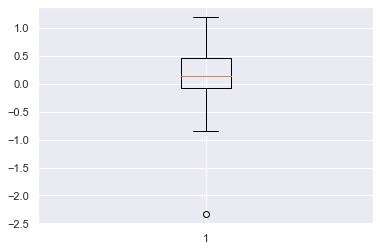

In [159]:
plt.boxplot(agent_objectives[0]);

In [ ]:
#IC_objective.to_csv('../data/IC_objective_pessimistic_2000_2.csv')